In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#survival analysis lib
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.utils import restricted_mean_survival_time, k_fold_cross_validation


In [2]:
#dummfiied elsewhere
telco = pd.read_csv('../data/telco_clustered.csv')
pd.set_option('display.max_columns',99)

## Survival Analysis

measures the estimated death with right censorship 

### Kaplan Meier

Estimation of survival function 

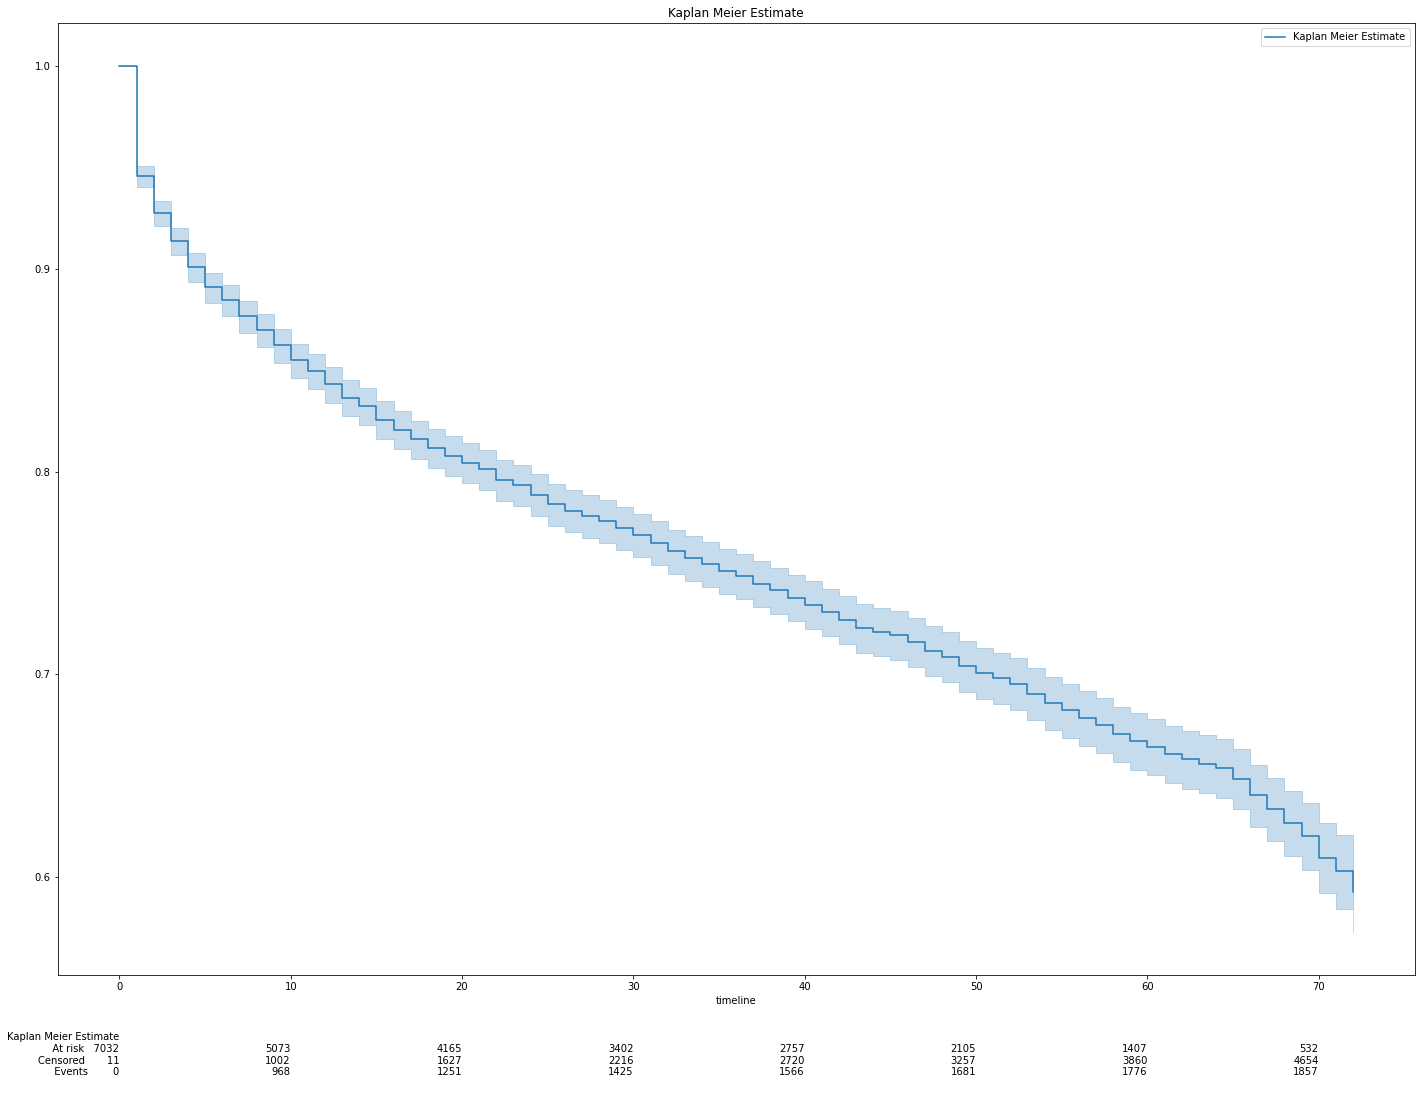

In [4]:
duration = telco['tenure_months'] 
event_observed = telco['customer_status']  

# instantiate km
km = KaplanMeierFitter() 

#plot figure
plt.figure(figsize=(20,15))
# Fit
km.fit(duration, event_observed,label='Kaplan Meier Estimate')

# Create an estimate
km.plot_survival_function(at_risk_counts=True)

plt.title('Kaplan Meier Estimate')
plt.show()

In [5]:
km.median_survival_time_

inf

## Cohorts

In [43]:
telco.cluster.value_counts(normalize=True)

price_sensitive    0.275309
vanilla            0.255573
heavyweight        0.252307
minimalist         0.216811
Name: cluster, dtype: float64

Restricted Mean Survival Time Vanilla: 38.913504228425595
Restricted Mean Survival Time Heavyweight: 49.757277333026366
Restricted Mean Survival Time Minimalist: 46.51885717339057
Restricted Mean Survival Time Price Sensitive: 24.46693462293565


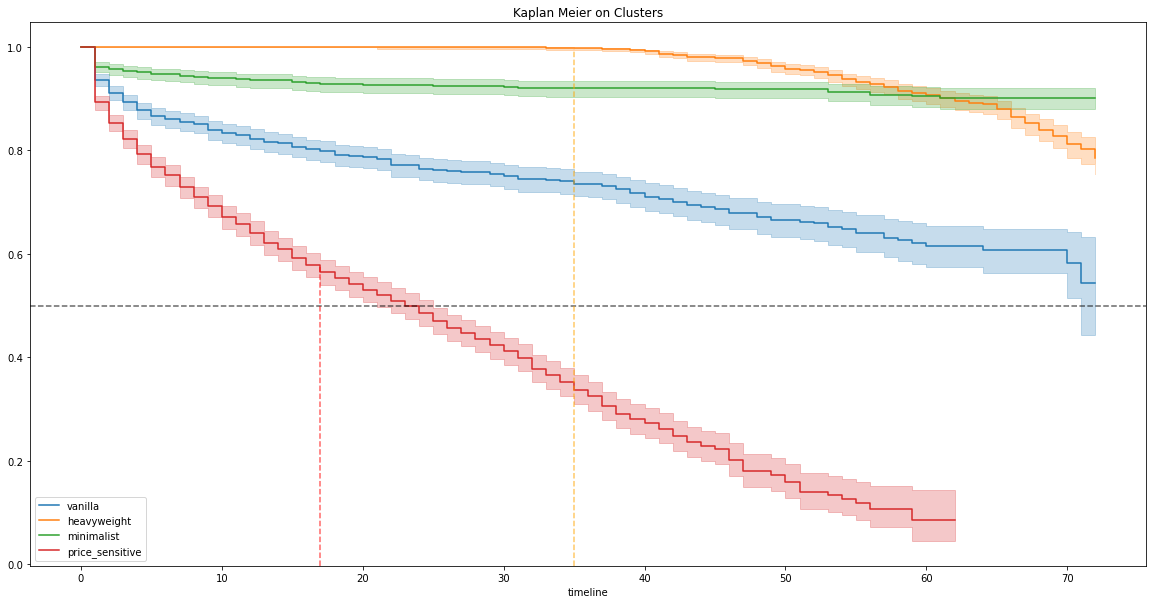

In [56]:
#instantiater
kmf = KaplanMeierFitter() 

T = telco['tenure_months']      #time to the event
E = telco['customer_status']    #event occurred or censored
  
#cohorts
x1 = (telco['cluster']  == 'vanilla')   
x2 = (telco['cluster']  == 'heavyweight')    
x3 = (telco['cluster']  == 'minimalist')        
x4 = (telco['cluster']  == 'price_sensitive')  

#define time limit 
time_limit = 50

#plot figure
plt.figure(figsize=(20,10))

kmf_v = kmf.fit(T[x1], E[x1], label='vanilla')  
rmst_v = restricted_mean_survival_time(kmf_v, t=time_limit)
print(f'Restricted Mean Survival Time Vanilla: {rmst_v}')
ax = kmf.plot()

kmf_h = kmf.fit(T[x2], E[x2], label='heavyweight')  
rmst_h = restricted_mean_survival_time(kmf_h, t=time_limit)
print(f'Restricted Mean Survival Time Heavyweight: {rmst_h}')
ax1 = kmf.plot(ax=ax)

kmf_m = kmf.fit(T[x3], E[x3], label='minimalist') 
rmst_m = restricted_mean_survival_time(kmf_m, t=time_limit)
print(f'Restricted Mean Survival Time Minimalist: {rmst_m}')
ax2 = kmf.plot(ax=ax1)  

kmf_p = kmf.fit(T[x4], E[x4], label='price_sensitive')   
rmst_p = restricted_mean_survival_time(kmf_p, t=time_limit)
print(f'Restricted Mean Survival Time Price Sensitive: {rmst_p}')
kmf.plot(ax=ax2)  

plt.axhline(y=0.5, c='k', alpha=0.6, linestyle='--')
plt.title('Kaplan Meier on Clusters')
plt.legend(loc='lower left')
plt.axvline(x=17, ymax=0.55,c='r', alpha=0.6, linestyle='--')
plt.axvline(x=35,ymax=0.95, c='orange', alpha=0.6, linestyle='--')


plt.show()

Test other categorical 

### Cox Proportional Hazard Model 

Association between the survival time of customer and one or more predictor variables. between covairates (given ratio between groups)

assumptions
1. non information censoring, 
2. survival times are independent
3. hazard ratio constant - check with clog log or schoenfldt
4. log hazard func is linear function of the X's (numerical)  - residual plot/weibull
5. value of X dont change over time
6. baseline hazard is unspecified 

In [12]:
telco.columns

Index(['gender', 'age', 'under_30', 'senior_citizen', 'married', 'dependents',
       'number_of_dependents', 'city', 'tenure_months', 'phone_service',
       'multiple_lines', 'internet_service', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'contract', 'paperless_billing', 'payment_method',
       'churn_value', 'churn_score', 'cltv', 'churn_reason',
       'referred_a_friend', 'number_of_referrals', 'offer',
       'avg_monthly_long_distance_charges', 'internet_type',
       'avg_monthly_gb_download', 'streaming_music', 'unlimited_data',
       'monthly_charge', 'total_charges', 'total_refunds',
       'total_extra_data_charges', 'total_long_distance_charges',
       'total_revenue', 'satisfaction_score', 'customer_status',
       'churn_category', 'pop_density', 'new_user', 'cluster'],
      dtype='object')

In [31]:
cph = CoxPHFitter()

cph.fit(telco, duration_col='tenure_months', event_col='customer_status', 
       formula="gender + senior_citizen + married + number_of_dependents + phone_service + multiple_lines + internet_service + online_security + online_backup + device_protection + tech_support + streaming_tv + streaming_movies + contract + paperless_billing + payment_method + number_of_referrals + offer + satisfaction_score + monthly_charge")


<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>

less than 0.05 is statistically significant difference.denotes that we have to reject our null hypothesis and admit that the survival function for both groups is significantly different.

In [38]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure_months'
                event col = 'customer_status'
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -12341.31
         time fit was run = 2021-05-16 04:24:01 UTC

---
                                            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                         
contract[T.One year]                       -1.01       0.37       0.09            -1.19            -0.83                 0.30                 0.44
contract[T.Two year]                       -2.54       0.08       0.17            -2.88            -2.20                 0.06                 0.11
device_protection                          -0.37       0.69       0.13            -0.62            -0.12                 0.54                 0.88
gender                                      0.11       1.12       0.05             0.02             0.20                 1.02                 1.23
internet_service[T.Fiber optic]            -0.66       0.52       0.59            -1.81             0.50                 0.16                 1.65
internet_service[T.No]                      0.17       1.19       0.60            -1.01             1.35                 0.37                 3.86
married                                    -0.04       0.96       0.06            -0.17             0.09                 0.85                 1.09
monthly_charge                              0.03       1.03       0.02            -0.01             0.08                 0.99                 1.08
multiple_lines                             -0.64       0.53       0.13            -0.89            -0.38                 0.41                 0.69
number_of_dependents                       -0.16       0.85       0.05            -0.26            -0.07                 0.77                 0.93
number_of_referrals                        -0.24       0.79       0.03            -0.29            -0.18                 0.75                 0.83
offer[T.Offer A]                           -0.99       0.37       0.18            -1.35            -0.63                 0.26                 0.53
offer[T.Offer B]                           -0.79       0.45       0.11            -1.00            -0.58                 0.37                 0.56
offer[T.Offer C]                           -0.32       0.72       0.11            -0.54            -0.11                 0.58                 0.90
offer[T.Offer D]                            0.04       1.04       0.09            -0.13             0.22                 0.88                 1.24
offer[T.Offer E]                            1.51       4.54       0.07             1.37             1.66                 3.93                 5.25
online_backup                              -0.66       0.51       0.13            -0.92            -0.41                 0.40                 0.67
online_security                            -0.93       0.40       0.14            -1.20            -0.66                 0.30                 0.52
paperless_billing                           0.03       1.03       0.06            -0.08             0.15                 0.92                 1.16
payment_method[T.Credit card (automatic)]  -0.12       0.89       0.09            -0.29             0.06                 0.75                 1.07
payment_method[T.Electronic check]          0.24       1.28       0.07             0.10             0.39                 1.11                 1.47
payment_method[T.Mailed check]              0.47       1.60       0.09             0.29             0.64                 1.34                 1.90
phone_service                              -0.49       0.61       0.48            -1.43   

exp(coef) , less than 1 lower risk of death, longer median survival. (hazard ratio)
coef is the difference in log hazard func between two group (log instantaneous risk of death, is coef higher than other X. 
coef lower 95 and upper 95 is confidence interval to baseline hazard of death -1.19 times more -0.83 

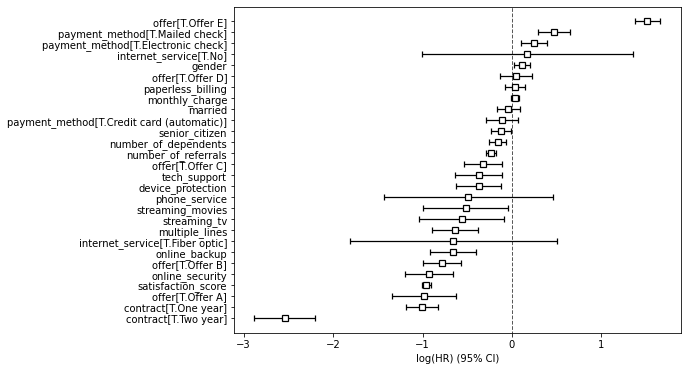

In [42]:
ax = plt.subplots(figsize=(8, 6))
cph.plot(ax=ax[1])
plt.show()

In [40]:
telco.head()

,gender,age,under_30,senior_citizen,married,dependents,number_of_dependents,city,tenure_months,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,churn_value,churn_score,cltv,churn_reason,referred_a_friend,number_of_referrals,offer,avg_monthly_long_distance_charges,internet_type,avg_monthly_gb_download,streaming_music,unlimited_data,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,satisfaction_score,customer_status,churn_category,pop_density,new_user,cluster
0,0,78,0,1,0,0,0,Los Angeles,1,0,0,DSL,0,0,1,0,0,1,Month-to-month,1,Electronic check,1,100,5433,Competitor offered more data,0,0,None,0.00,DSL,8,0,0,39.65,39.65,0.00,20,0.00,59.65,3,1,Competitor,15334,0,vanilla
1,1,74,0,1,1,1,1,Los Angeles,8,1,1,Fiber optic,0,1,0,0,0,0,Month-to-month,1,Credit card (automatic),1,69,5302,Competitor made better offer,1,1,Offer E,48.85,Fiber Optic,17,0,1,80.65,633.30,0.00,0,390.80,1024.10,3,1,Competitor,17038,0,price_sensitive
2,0,71,0,1,0,1,3,Los Angeles,18,1,1,Fiber optic,0,0,0,0,1,1,Month-to-month,1,Electronic check,1,81,3179,Competitor made better offer,0,0,Offer D,11.33,Fiber Optic,52,1,1,95.45,1752.55,45.61,0,203.94,1910.88,2,1,Competitor,8625,0,price_sensitive
3,1,78,0,1,1,1,1,Inglewood,25,1,0,Fiber optic,0,1,1,0,1,1,Month-to-month,1,Electronic check,1,88,5337,Limited range of services,1,1,Offer C,19.76,Fiber Optic,12,0,1,98.50,2514.50,13.43,0,494.00,2995.07,2,1,Dissatisfaction,11799,0,price_sensitive
4,1,80,0,1,1,1,1,Whittier,37,1,1,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Electronic check,1,67,2793,Extra data charges,1,1,Offer C,6.33,Fiber Optic,14,0,1,76.50,2868.15,0.00,0,234.21,3102.36,2,1,Price,6947,0,price_sensitive


## Quadrant division

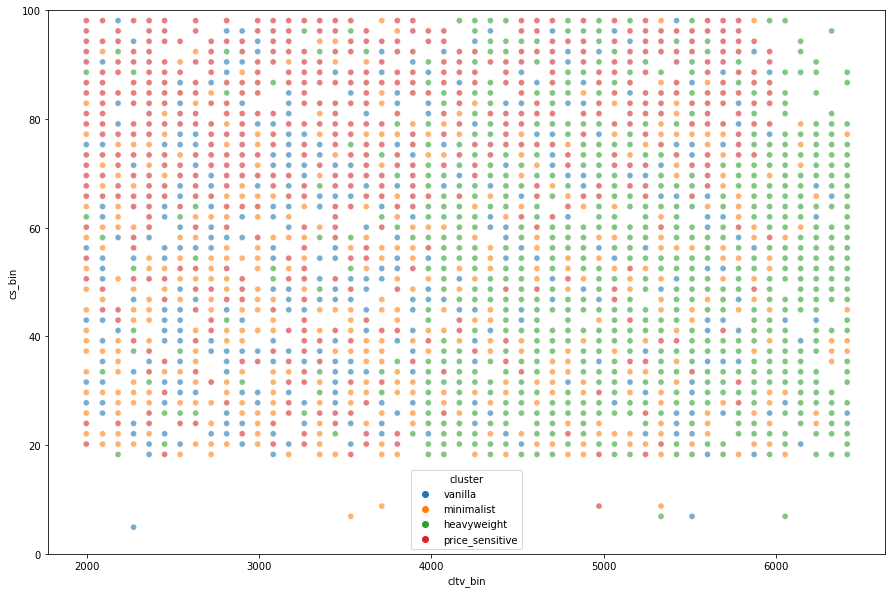

In [41]:
telco_quadrant = telco[['cltv','churn_score','cluster','satisfaction_score']].copy()
telco_quadrant['cs_bin'] = pd.cut(telco_quadrant['churn_score'], bins=50).apply(lambda x: x.left)
telco_quadrant['cltv_bin'] = pd.cut(telco_quadrant['cltv'], bins=50).apply(lambda x: x.left)
plot_df = telco_quadrant.groupby(['cs_bin', 'cltv_bin']).agg({'cluster': lambda x: x.mode()[0]}).reset_index()

plt.figure(figsize=(15,10))
sns.scatterplot(data=plot_df, x='cltv_bin',y='cs_bin', hue='cluster', alpha=0.6)
plt.ylim(0, 100)
plt.show()